# Parametric Dynamic Mode Decomposition - TWIGL Reactor (dolfinx)
Transients in a Multi-Physics model of a TWIGL-like reactor are solved with dolfinx is used. The absorption cross section of the thermal group in the central region of the reactor follows this shape over time
\begin{equation*}
\Sigma_a\sim 1.01 - \frac{0.02}{1 + e^{-5t}} + 0.002 \cdot \sin(\omega \cdot 2\pi t)
\end{equation*}
Different values of $\omega$ are considered, producing the data.

Four different versions will be compared in this notebook:

1. Reduced Operator Interpolation with standard DMD - (rOp)
2. Reduced Koopman Operator Interpolation with OptDMD (rKOp)
3. Monolithic pDMD from pyDMD  - (pDMD-mono)
4. Partitioned pDMD from pyDMD - (pDMD-part)

The snapshots are loaded from `data/twiglData.npz`, which contains the fast flux, thermal flux and temperature at different values of $\omega$ numbers. Each field dataset is a 3D array with dimensions $(N_s,N_t, \mathcal{N}_h)$, where $N_s$ is the number of parameters (number of Reynolds evaluations), $N_t$ is the number of time instants, and $\mathcal{N}_h$ is the number of spatial points.

In [1]:
import numpy as np

data = np.load('../data/twiglData.npz', allow_pickle=True)

# Extract the data
snaps = data['snapshots'].item()
omega = data['omega']
times = data['fom_times']
domain = data['mesh']

var_names = list(snaps.keys())
tex_var_names = [r'\phi_1', r'\phi_2', 'T']
assert len(var_names) == len(tex_var_names)

Ns = snaps[var_names[0]].shape[0]
Nt = len(times)
Nh = domain.shape[0]

gdim = 2 # 2D geometry

assert Ns == len(omega)
assert Nt == len(times)
assert Nh == domain.shape[0]

print(f'Number of snapshots: {Ns}')
print(f'Number of time steps: {Nt}')
print(f'Number of mesh nodes: {Nh}')

# Define plotter class
import sys
sys.path.append('../')

from tools.plots import PlotTWIGL

plotter = PlotTWIGL(domain)

Number of snapshots: 49
Number of time steps: 401
Number of mesh nodes: 3594


Here the path for results is defined

In [2]:
import os
path_res = 'Results/04_TWIGL/'
os.makedirs(path_res, exist_ok=True)

Let us define the train and test set for the Reynolds number in range $[100,150]$.

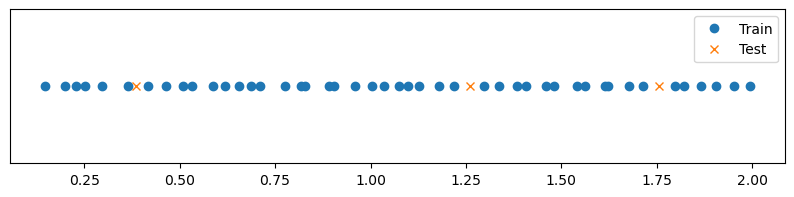

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(5)
train_idx, test_idx = train_test_split(np.arange(len(omega)), test_size = 0.05)

fig = plt.figure(figsize=(10,2))
plt.plot(omega[train_idx], np.zeros_like(train_idx), 'o', label='Train')
plt.plot(omega[test_idx], np.zeros_like(test_idx), 'x', label='Test')
plt.legend()
plt.yticks([])

train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

fig.savefig(path_res + 'train_test_split.pdf', format='pdf', dpi=200, bbox_inches='tight')

Since the fields have different magnitudes, we will scale all in [0,1].

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaling = False

if scaling:

    scaler_snaps = {field: MinMaxScaler() for field in var_names}
    rescaled_snaps = {field: np.zeros_like(snaps[field]) for field in var_names}

    for field in var_names:
        scaler_snaps[field] = scaler_snaps[field].fit(snaps[field].reshape(-1, Nh))
        rescaled_snaps[field] = scaler_snaps[field].transform(snaps[field].reshape(-1, Nh)).reshape(Ns, Nt, Nh)

else:
    rescaled_snaps = snaps

Let us split the data, saved as
\begin{equation*}
  N_p^{train} \times N_t \times N_h \qquad\text{ and } \qquad N_p^{test} \times N_t \times N_h
\end{equation*}

In [5]:
train_snapshots = np.zeros((len(train_idx), Nt, Nh*len(var_names))) # *len(var_names) is due to the fact that we have more than 1 field
test_snapshots  = np.zeros((len(test_idx),  Nt, Nh*len(var_names)))

for i, idx in enumerate(train_idx):
    for field_i, field in enumerate(var_names):
        train_snapshots[i, :, field_i * Nh : (field_i+1) * Nh] = rescaled_snaps[field][idx]

for i, idx in enumerate(test_idx):
    for field_i, field in enumerate(var_names):
        test_snapshots[i, :, field_i * Nh : (field_i+1) * Nh] = rescaled_snaps[field][idx]

Let us make a plot of the average values of the different fields over time

Text(0, 0.5, 'Mean value')

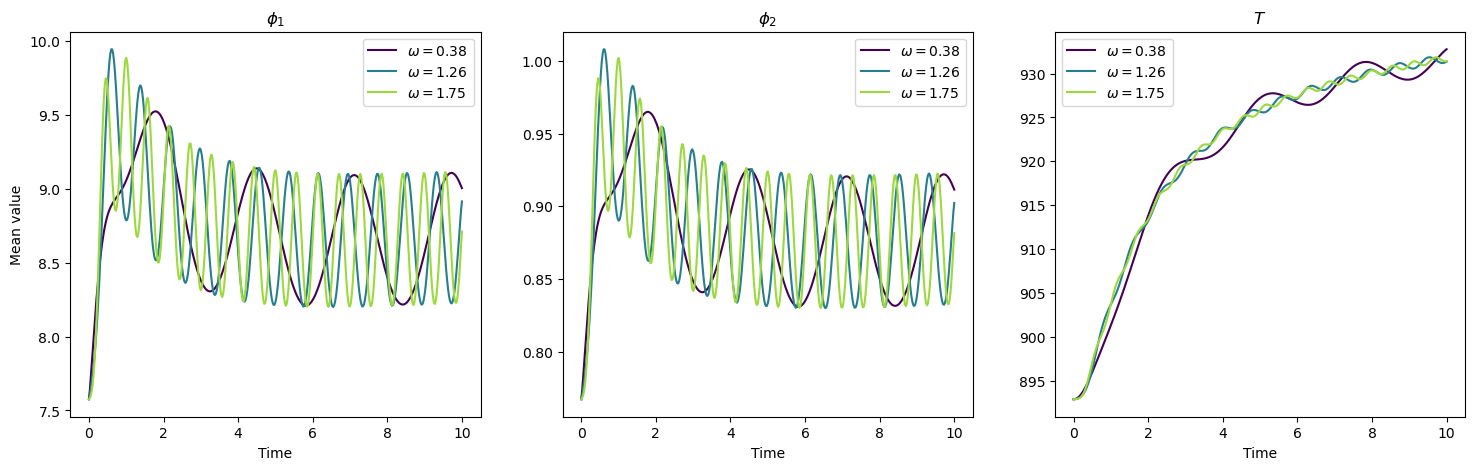

In [6]:
from matplotlib import cm

fig, axs = plt.subplots(1, len(var_names), figsize=(6 * len(var_names), 5))

colors = cm.viridis(np.linspace(0, 0.85, len(test_idx)))

for field_i, field in enumerate(var_names):
    _snap = test_snapshots[:, :, field_i*Nh:(field_i+1)*Nh]
    for i, idx in enumerate(test_idx):
        axs[field_i].plot(times, _snap[i, :].mean(axis=-1), color=colors[i], label=f'$\omega = {omega[idx]:.2f}$')

    axs[field_i].set_title('${}$'.format(tex_var_names[field_i]))
    axs[field_i].set_xlabel('Time')
    axs[field_i].legend()

axs[0].set_ylabel('Mean value')

## Preliminary SVD to assess the rank
The Singular Value Decomposition is used to assess the reducibility of the data (the use of randomized version allows for a much quicker decomposition) by observing the decay of the singular values.

In [7]:
from sklearn.utils.extmath import randomized_svd

rank = 20
spatial_modes, sing_vals, _ = randomized_svd(train_snapshots.reshape(-1, Nh*len(var_names)).T, n_components=rank, n_iter='auto')

Let us plot the eigenvalues

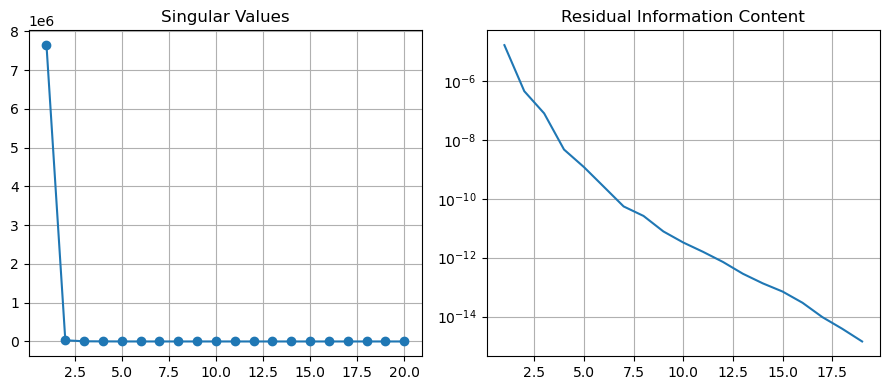

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].plot(np.arange(1, rank+1, 1), sing_vals, '-o')
axs[0].set_title('Singular Values')

axs[1].semilogy(np.arange(1, rank, 1), 1-np.cumsum(sing_vals[:-1]**2) / np.sum(sing_vals**2), '-')
axs[1].set_title('Residual Information Content')

for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')

plt.tight_layout()
fig.savefig(path_res + 'svd_analysis.pdf', format='pdf', dpi=200, bbox_inches='tight')

Let us compute the reduced coefficient from which the DMD models will be created. 

Given the snapshot matrix $\mathbb{X}\in\mathbb{R}^{\mathcal{N_h}\times(N_t\cdot N_s^{train})}$, the reduced coefficient is computed as $\mathbb{V} = \mathbb{U}^T\mathbb{X}$, where $\mathbb{U}\in\mathbb{R}^{\mathcal{N}_h\times r}$ is the matrix containing the spatial SVD modes and $\mathbb{V}\in\mathbb{R}^{r\times (N_t\cdot N_s^{train})}$ - same for test set.

In [9]:
train_pod_coeff = np.dot(spatial_modes.T, train_snapshots.reshape(-1, Nh*len(var_names)).T) # rank x (Nt * Ns_train)
test_pod_coeff  = np.dot(spatial_modes.T, test_snapshots.reshape(-1,  Nh*len(var_names)).T)  # rank x (Nt * Ns_test)

# Reshape the POD coefficients
train_pod_coeff = train_pod_coeff.T.reshape(len(train_idx), Nt, rank)
test_pod_coeff  = test_pod_coeff.T.reshape(len(test_idx), Nt, rank)

Let us make a plot of the SVD modes

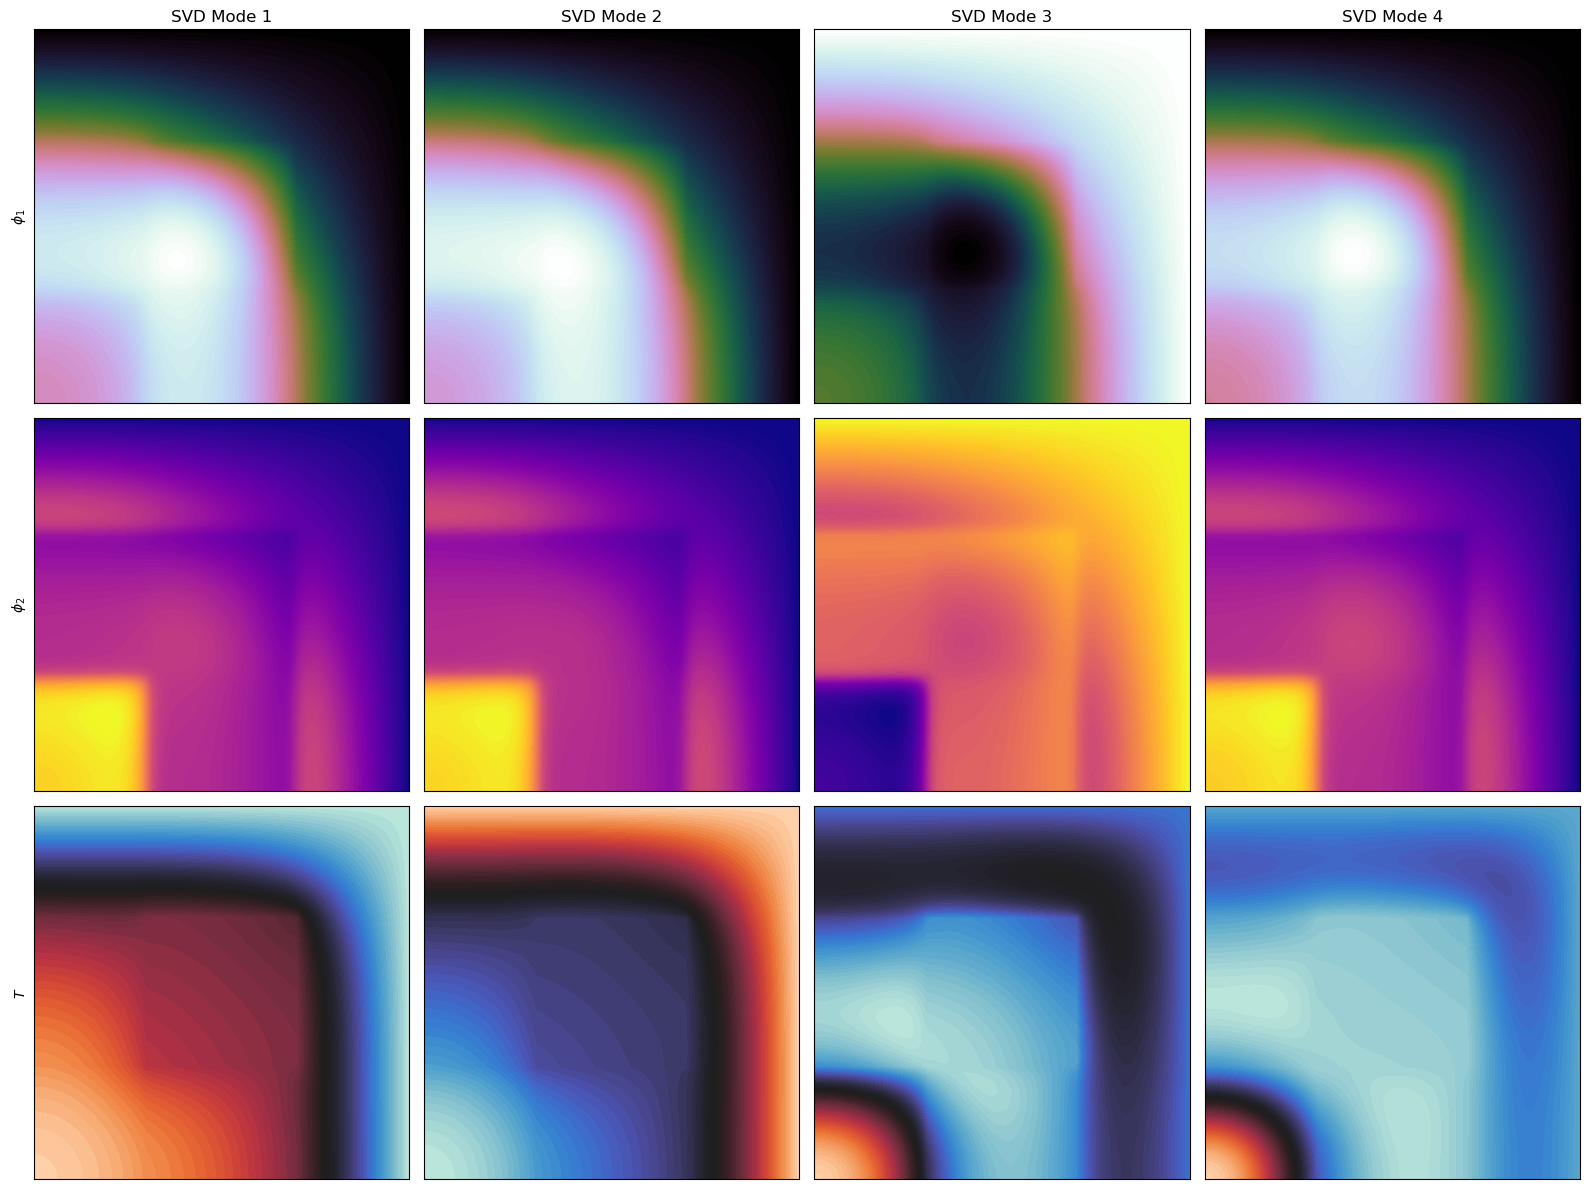

In [10]:
import seaborn as sns
cmaps = [sns.color_palette("cubehelix", as_cmap=True),
         sns.color_palette("plasma", as_cmap=True),
         sns.color_palette("icefire", as_cmap=True)]

nrows = len(var_names)
ncols = 4

modes_to_plot = np.arange(0, ncols, 1)

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * plotter.aspect * nrows))

for field_i in range(len(var_names)):
    for ii, idx in enumerate(modes_to_plot):
        plotter.plot_contour(axs[field_i, ii], spatial_modes[field_i * Nh : (field_i+1) * Nh, idx], cmap = cmaps[field_i], levels=100)
    
        if field_i == 0:
            axs[0, ii].set_title(f'SVD Mode {idx+1}')

        if ii == 0:
            axs[field_i, ii].set_ylabel(r'${}$'.format(tex_var_names[field_i]))

plt.tight_layout()

fig.savefig(path_res + 'spatial_modes.png', format='png', dpi=200, bbox_inches='tight')

Let us make a plot of the reduced coefficient for a random training coefficient

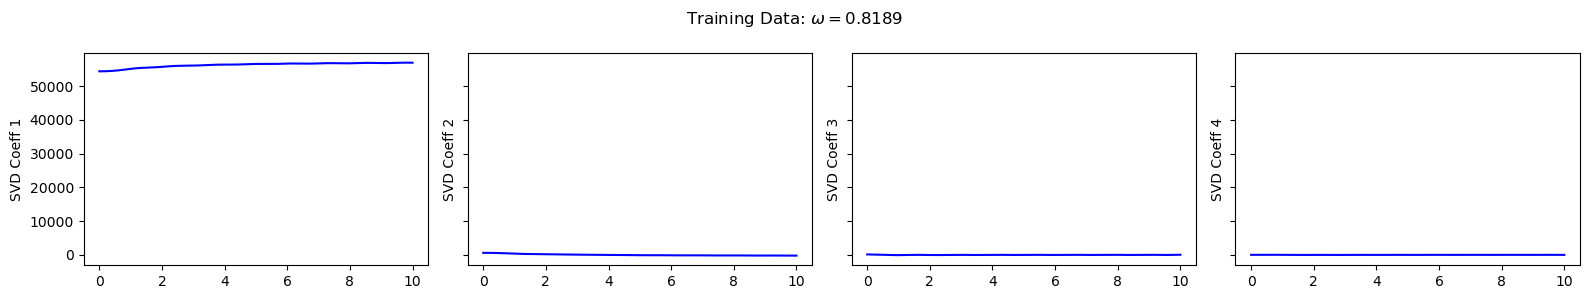

In [ ]:
param_to_plot = np.random.choice(len(train_idx), 1, replace=False)

fig, axs = plt.subplots(1, ncols, sharex=True, sharey=True, figsize=(4 * ncols, 3))
axs = axs.flatten()

for ii, idx in enumerate(modes_to_plot):
    axs[ii].plot(times, train_pod_coeff[param_to_plot, :, idx].T, 'b', label='$\omega = %.2f$' % omega[train_idx[param_to_plot]][0])
    axs[ii].set_ylabel(f'SVD Coeff {idx+1}')

    if ii >= (nrows-1)*ncols:
        axs[ii].set_xlabel('Time')

fig.suptitle(f'Training Data: $\omega = {omega[train_idx[param_to_plot]][0]}$')
plt.tight_layout()

## Reduced Operator Interpolation with standard DMD - rOp

This version builts DMD models (with standard algorithm) for each training parameters and then interpolates the DMD operators to predict the test set.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from tools.backends import ReducedOperatorInterpolation

rank_roi = 10
roi = ReducedOperatorInterpolation(rank = rank_roi)
roi.fit(train_pod_coeff, train_time=times, test_time=times, scaler = MinMaxScaler(), verbose=True)

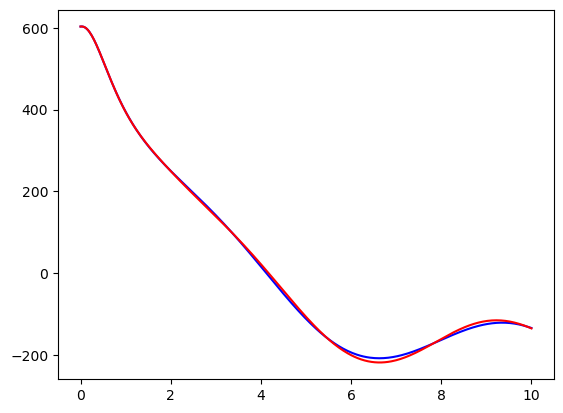

In [13]:
plt.plot(times, train_pod_coeff[0, :, 1], 'b', label='True')
plt.plot(times, roi.scaler.inverse_transform(roi.dmds[0].reconstructed_data.real.T).T[1], 'r', label='Reconstructed')

Let us make some contour plots of the reconstruction of the DMD models for training parameters

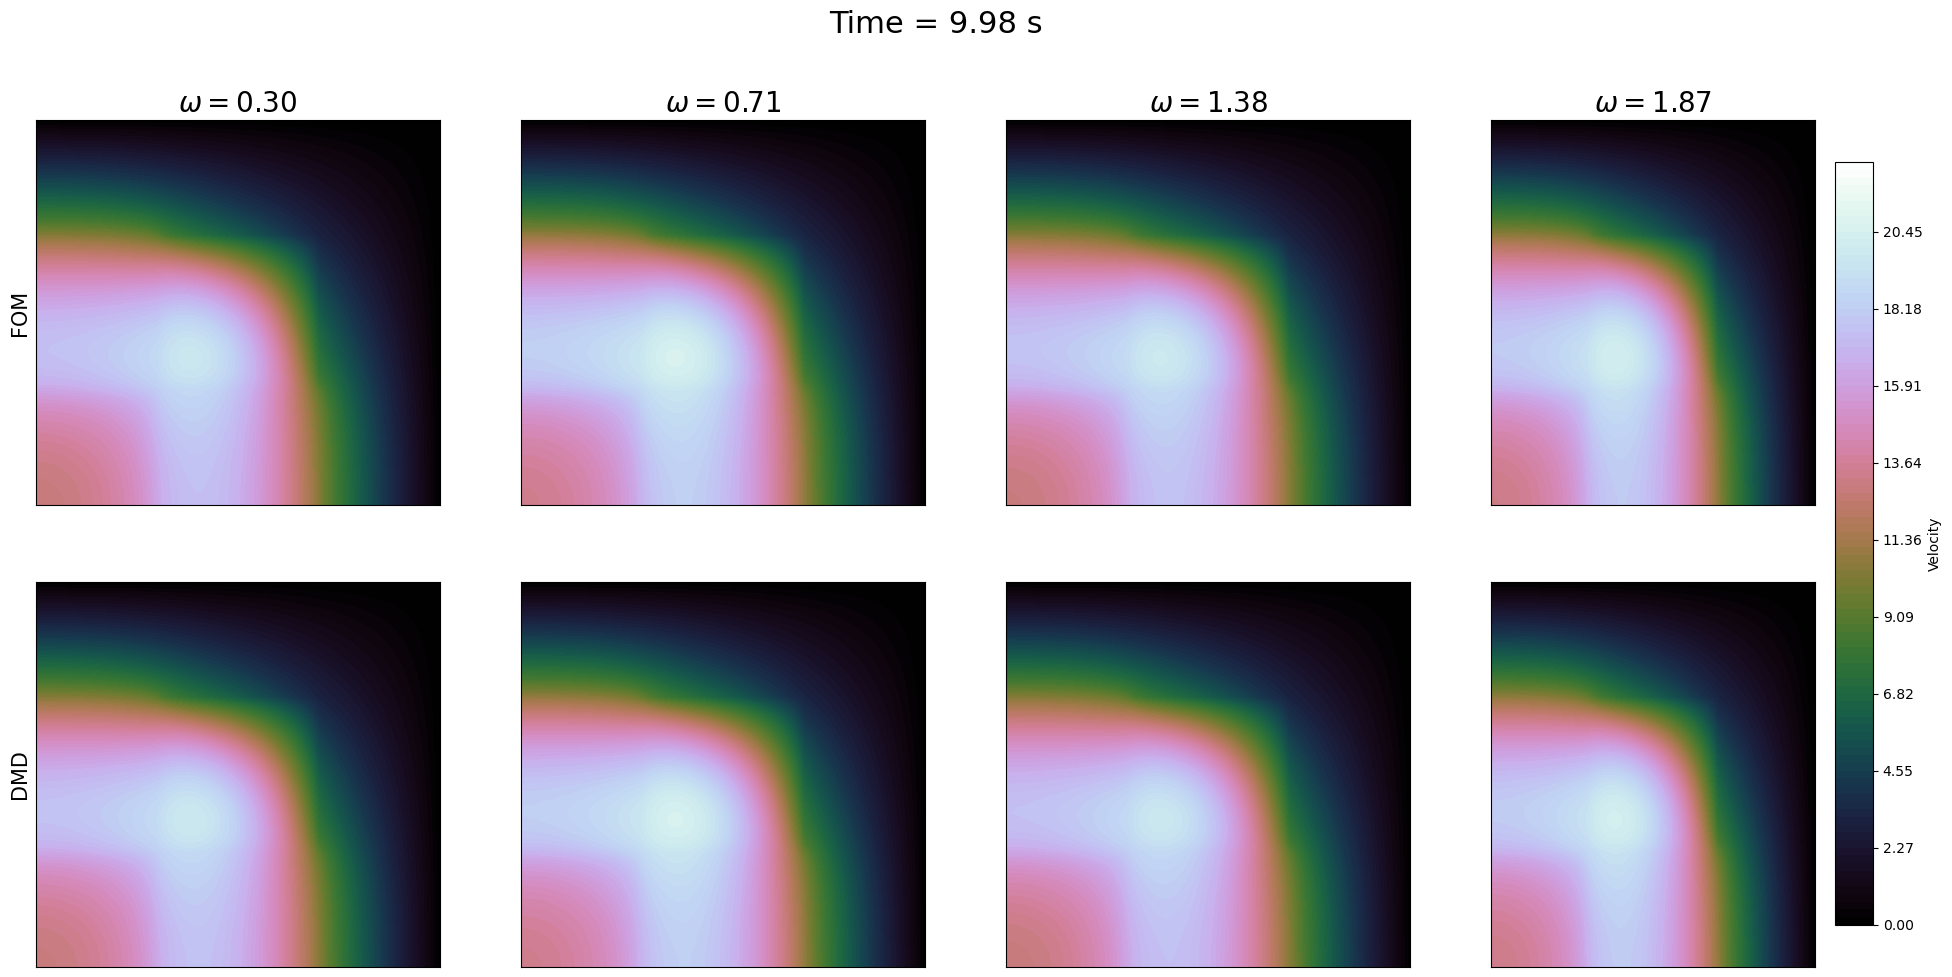

In [15]:
from tools.backends import dmd_reconstruct
from IPython.display import clear_output as clc

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_idx), 4, replace=False))
field_to_plot = 0

recons = [[dmd_reconstruct(roi.dmds[mu_i], spatial_modes[:, :roi.rank], scaler = roi.scaler, time=None) for mu_i in params_to_plot]]
labels = ['DMD']
if scaling:
    levels = [  np.linspace(0, 1, 100)] * len(var_names)
else:
    levels = [  np.linspace(0, 22.5, 100),
                np.linspace(0, 3.2, 100),
                np.linspace(600, 1250, 100)]

for tt in range(49, len(times), 25):
    fig, axs = plotter.plotting_reconstruction( params_to_plot, train_snapshots, omega, times, tt, 
                                               field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

### Reduction of the DMD operators
Once a DMD model has been built for each parametric realization, we are looking for a generic parametric representation of the DMD models. The operators are collected and reshaped in $\mathbb{A} = \begin{bmatrix} \mathbb{A}_1 & \mathbb{A}_2 & \cdots & \mathbb{A}_{N_s} \end{bmatrix}$, where $\mathbb{A}_i\in\mathbb{R}^{r\times r}$ is the DMD operator for the $i$-th parametric realization so that we can compress the DMD operators using the SVD

In [16]:
roi.reduce_operators(rank_op_svd=len(train_idx))
roi.get_op_interpolants(omega[train_idx], interp='linear')

Let us observe if the latent dynamics is well reconstructed by the pDMD method for test parameters

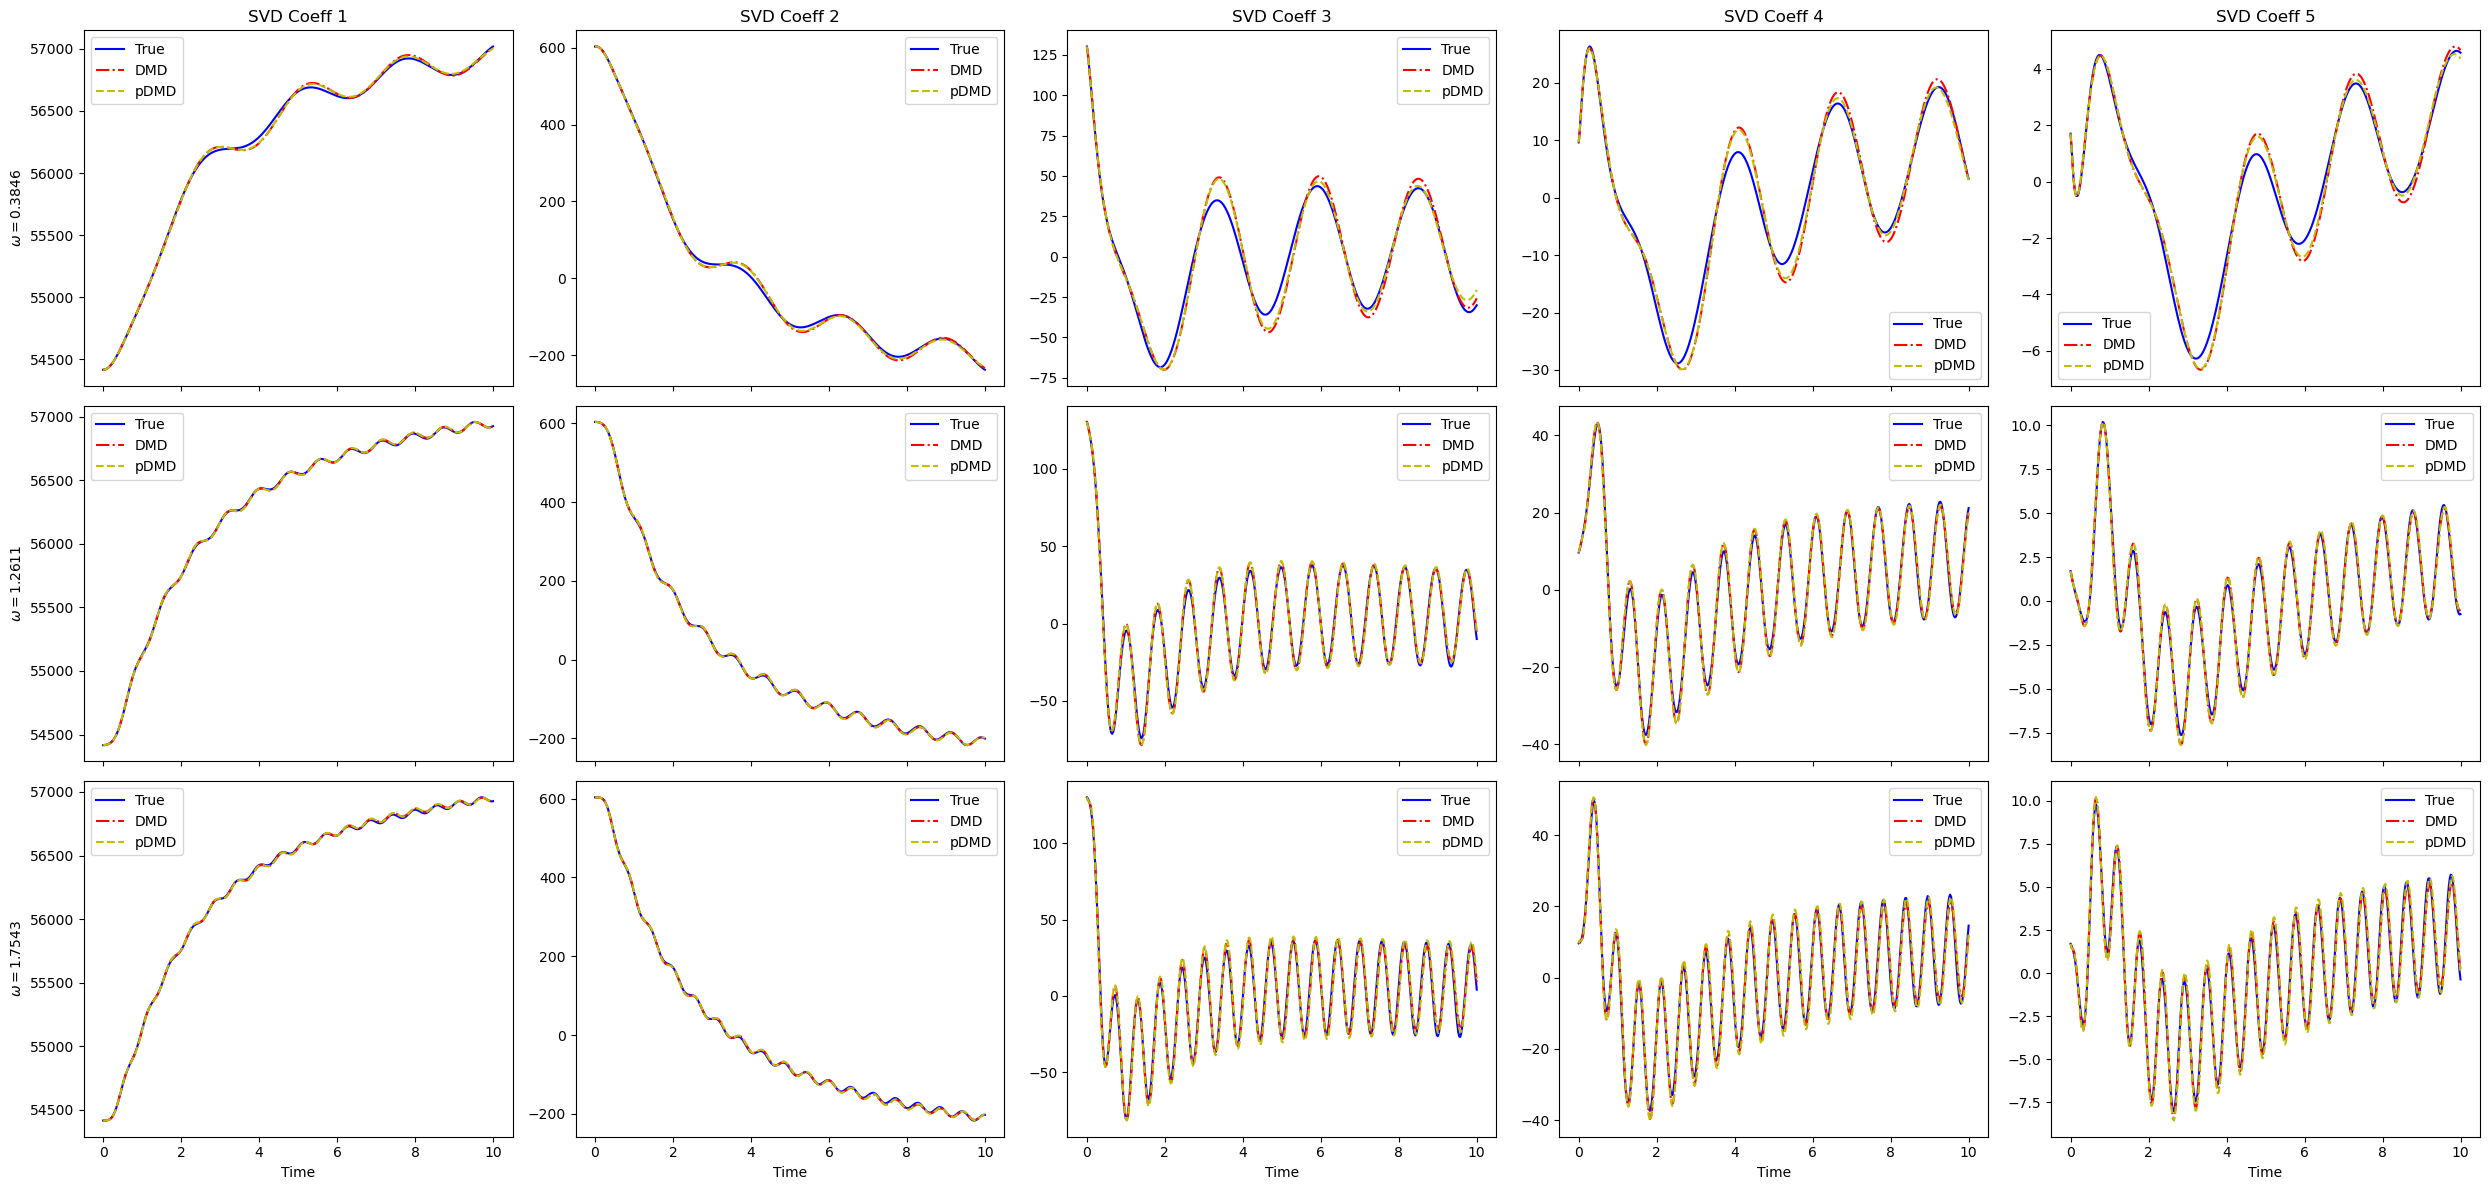

In [20]:
from pydmd import DMD

modes_to_plot = np.arange(0, 5, 1)

# Save for future use
dmds_test = dict()

fig, axs = plt.subplots(len(test_idx), len(modes_to_plot), sharex=True, figsize=(len(modes_to_plot)*5, len(test_idx)*4))

for mu_test in range(len(test_idx)):

    if roi.scaler is not None:  
        _scaled_test_pod_coeff = roi.scaler.transform(test_pod_coeff[mu_test, :, :roi.rank].reshape(-1, roi.rank))
    else:
        _scaled_test_pod_coeff = test_pod_coeff[mu_test, :, :roi.rank].reshape(-1, roi.rank)
    _dmd_test = DMD(svd_rank=-1)
    _dmd_test.fit(_scaled_test_pod_coeff.T)

    _dmd_test.original_time["t0"]   = times[0]
    _dmd_test.original_time["tend"] = times[-1] - 1e-12
    _dmd_test.original_time["dt"]   = times[1]  - times[0]

    _dmd_test.dmd_time["t0"]   = times[0]
    _dmd_test.dmd_time["tend"] = times[-1] - 1e-12
    _dmd_test.dmd_time["dt"]   = times[1]  - times[0]

    dmds_test[mu_test] = _dmd_test

    if roi.scaler is not None:  
        dmd_rec_pod_coeff   = roi.scaler.inverse_transform(_dmd_test.reconstructed_data.T.real).T
    else:   
        dmd_rec_pod_coeff   = _dmd_test.reconstructed_data.T.real.T
        
    predicted_pod_coeff = roi.advance(test_pod_coeff[mu_test, 0, :roi.rank], len(times), omega[test_idx][mu_test])

    for ii, idx in enumerate(modes_to_plot):
        axs[mu_test, ii].plot(times, test_pod_coeff[mu_test, :, idx], 'b', label='True')
        axs[mu_test, ii].plot(times, dmd_rec_pod_coeff[idx], 'r-.', label='DMD')
        axs[mu_test, ii].plot(times, predicted_pod_coeff[:, idx], 'y--', label='pDMD')
        axs[mu_test, ii].legend()

        if mu_test == 0:
            axs[mu_test, ii].set_title(f'SVD Coeff {idx+1}')
            
        if ii == 0:
            axs[mu_test, ii].set_ylabel(f'$\omega = {omega[test_idx][mu_test]}$')

        if mu_test == len(test_idx)-1:
            axs[mu_test, ii].set_xlabel('Time')

plt.tight_layout()
fig.savefig(path_res + 'pdmd_roi_test_latent_dyn.pdf', format='pdf', dpi=200, bbox_inches='tight')

Let us observed if the eigenvalues of each test DMD model are well reconstructed by the pDMD method on the complex plane

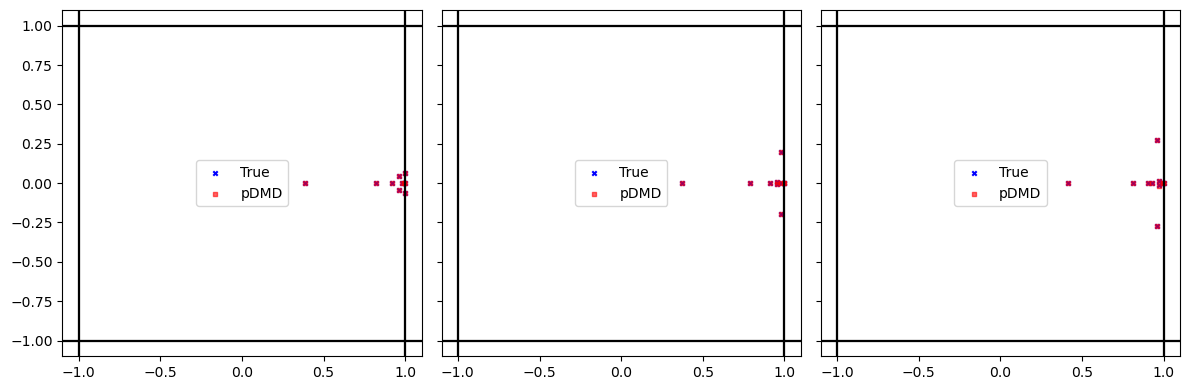

In [21]:
fig, axs = plt.subplots(1, len(test_idx), sharex=True, sharey=True, figsize=(len(test_idx)*4, 4))


for mu_test in range(len(test_idx)):

    rec_Aop = roi.predict_op(omega[test_idx][mu_test]).reshape(rank_roi, rank_roi)

    # Compute true DMD operator
    _U, _, _ = dmds_test[mu_test].operator.compute_operator(dmds_test[mu_test].snapshots[:,:-1], 
                                                            dmds_test[mu_test].snapshots[:,1:])
    true_Aop = np.linalg.multi_dot([_U, dmds_test[mu_test].operator._Atilde, _U.T])

    axs[mu_test].scatter(np.linalg.eigvals(true_Aop).real, np.linalg.eigvals(true_Aop).imag, label='True', c='b', s=10, marker='x')
    axs[mu_test].scatter(np.linalg.eigvals(rec_Aop).real, np.linalg.eigvals(rec_Aop).imag, label='pDMD', c='r', s=10, marker='s', alpha=0.6)

    for ax in axs:
        ax.axvline( 1, color='k', linestyle='-')
        ax.axvline(-1, color='k', linestyle='-')
        ax.axhline( 1, color='k', linestyle='-')
        ax.axhline(-1, color='k', linestyle='-')
        ax.legend()

plt.tight_layout()

In the end, let us compare the results at the high-dimensional level

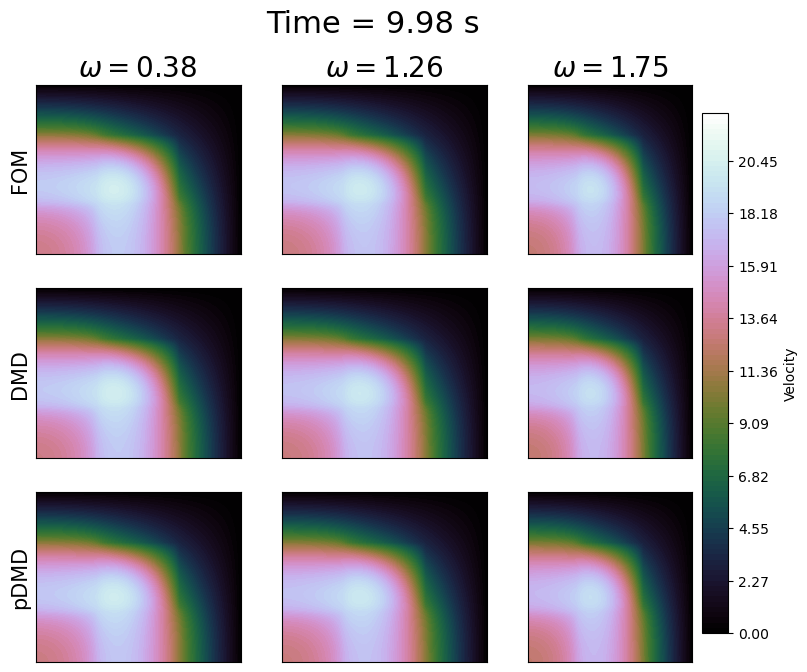

In [25]:
recons = list()
field_to_plot = 0

# Direct DMD
recons.append([dmd_reconstruct(dmds_test[mu_i], spatial_modes[:, :rank_roi], scaler = roi.scaler, time=None) for mu_i in range(len(test_idx))])

# pDMD
recons.append(list())
for i, mu_i in enumerate(test_idx):
    recons[-1].append(np.dot(spatial_modes[:, :rank_roi], 
                             roi.advance(test_pod_coeff[i, 0, :rank_roi], len(times), omega[mu_i]).T))

labels = ['DMD', 'pDMD']
for tt in range(49, len(times), 50):
    fig, axs = plotter.plotting_reconstruction( np.arange(0, len(test_idx), 1), test_snapshots, omega[test_idx], times, tt, 
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Reduced Koopman Operator Interpolation with OptDMD (rKOp)
This version builts DMD models (with OptDMD algorithm) for each training parameters and then interpolates the DMD operators to predict the test set.

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tools.backends import ReducedKoopmanOperatorInterpolation

rank_rkoi = 10
rkoi = ReducedKoopmanOperatorInterpolation(rank = rank_rkoi)
rkoi.fit(train_pod_coeff, train_time=times, scaler = MinMaxScaler(), 
         verbose=True, tol = 0.2, opt_verbose=False)

Let us make some contour plots of the reconstruction of the DMD models for training parameters

In [31]:

if scaling:
    levels = [  np.linspace(0, 1, 100)] * len(var_names)
else:
    levels = [  np.linspace(0, 22.5, 100),
                np.linspace(0, 3.5, 100),
                np.linspace(600, 1250, 100)]


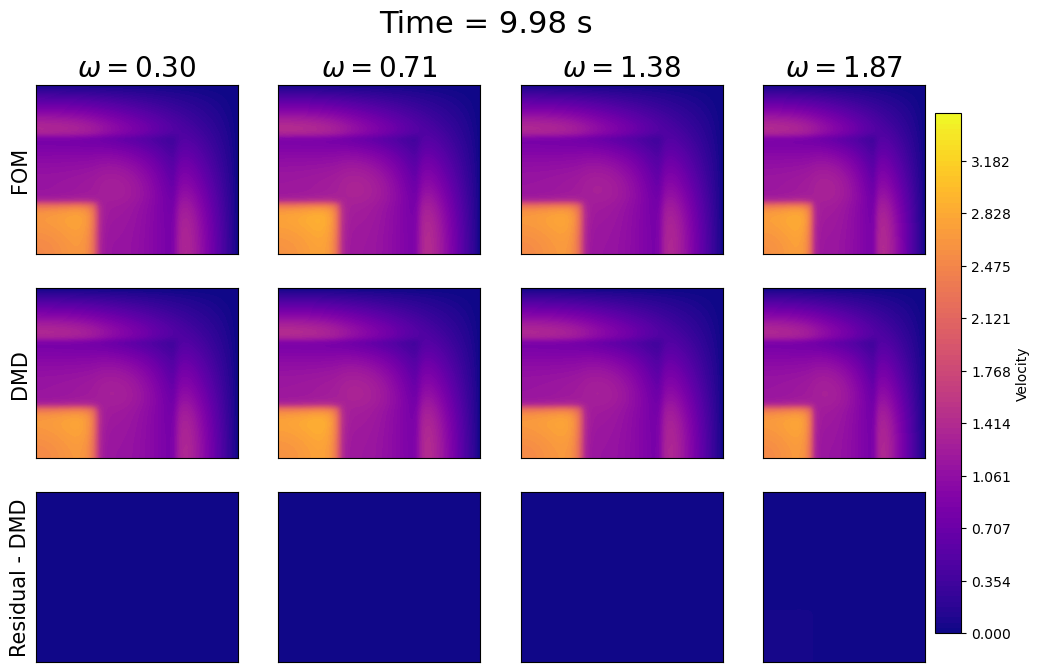

In [35]:
from tools.backends import dmd_reconstruct
from IPython.display import clear_output as clc

field_to_plot = 1

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_idx), 4, replace=False))

recons = [[dmd_reconstruct(rkoi.dmds[mu_i], spatial_modes[:, :rkoi.rank], scaler = rkoi.scaler, time=times) for mu_i in params_to_plot]]
labels = ['DMD']

for tt in range(49, len(times), 25):
    fig, axs = plotter.plotting_reconstruction( params_to_plot, train_snapshots, omega, times, tt, 
                            field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=True, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Once a DMD model has been built for each parametric realization, we are looking for a generic parametric representation of the DMD models.

The DMD forecasting is performed according to the following formula: to find the unknown state $\mathbf{x}(t)$
\begin{equation*}
\mathbf{x}(t) = \sum_{k=1}^{r} b_k \cdot  \boldsymbol{\phi}_k\cdot e^{\omega_k t}
\end{equation*}
where $ \boldsymbol{\phi}_k$ are the DMD modes, $\omega_k$ are the DMD eigenvalues, and $\mathbf{b}$ are the DMD amplitudes, according to https://github.com/PyDMD/PyDMD/blob/master/pydmd/bopdmd.py.


We need to interpolate the DMD modes, eigenvalues, and amplitudes to predict the test set.

In [36]:
rkoi.get_kop()
rkoi.get_kop_interpolants(omega[train_idx], interp = 'linear')

Let us compute the optimised DMD for the test set

In [37]:
from pydmd import BOPDMD

optdmds_test = dict()
for mu_test in range(len(test_idx)):

    print('DMD for test parameter %d' % mu_test, end='\r')

    if rkoi.scaler is not None:  
        _scaled_test_pod_coeff = rkoi.scaler.transform(test_pod_coeff[mu_test, :, :rkoi.rank].reshape(-1, rkoi.rank))
    else:
        _scaled_test_pod_coeff = test_pod_coeff[mu_test, :, :rkoi.rank].reshape(-1, rkoi.rank)
    _dmd_test = BOPDMD(
                                svd_rank=-1,
                                num_trials=0,                                    # Number of bagging trials to perform - 0 means no bagging.
                                varpro_opts_dict={"tol": 0.15, "verbose": False}, # Set convergence tolerance and use verbose updates.
                                compute_A = False,
                            )
    _dmd_test.fit(_scaled_test_pod_coeff.T, times)

    optdmds_test[mu_test] = _dmd_test


Let us observe if the latent dynamics is well reconstructed by the pDMD method for test parameters

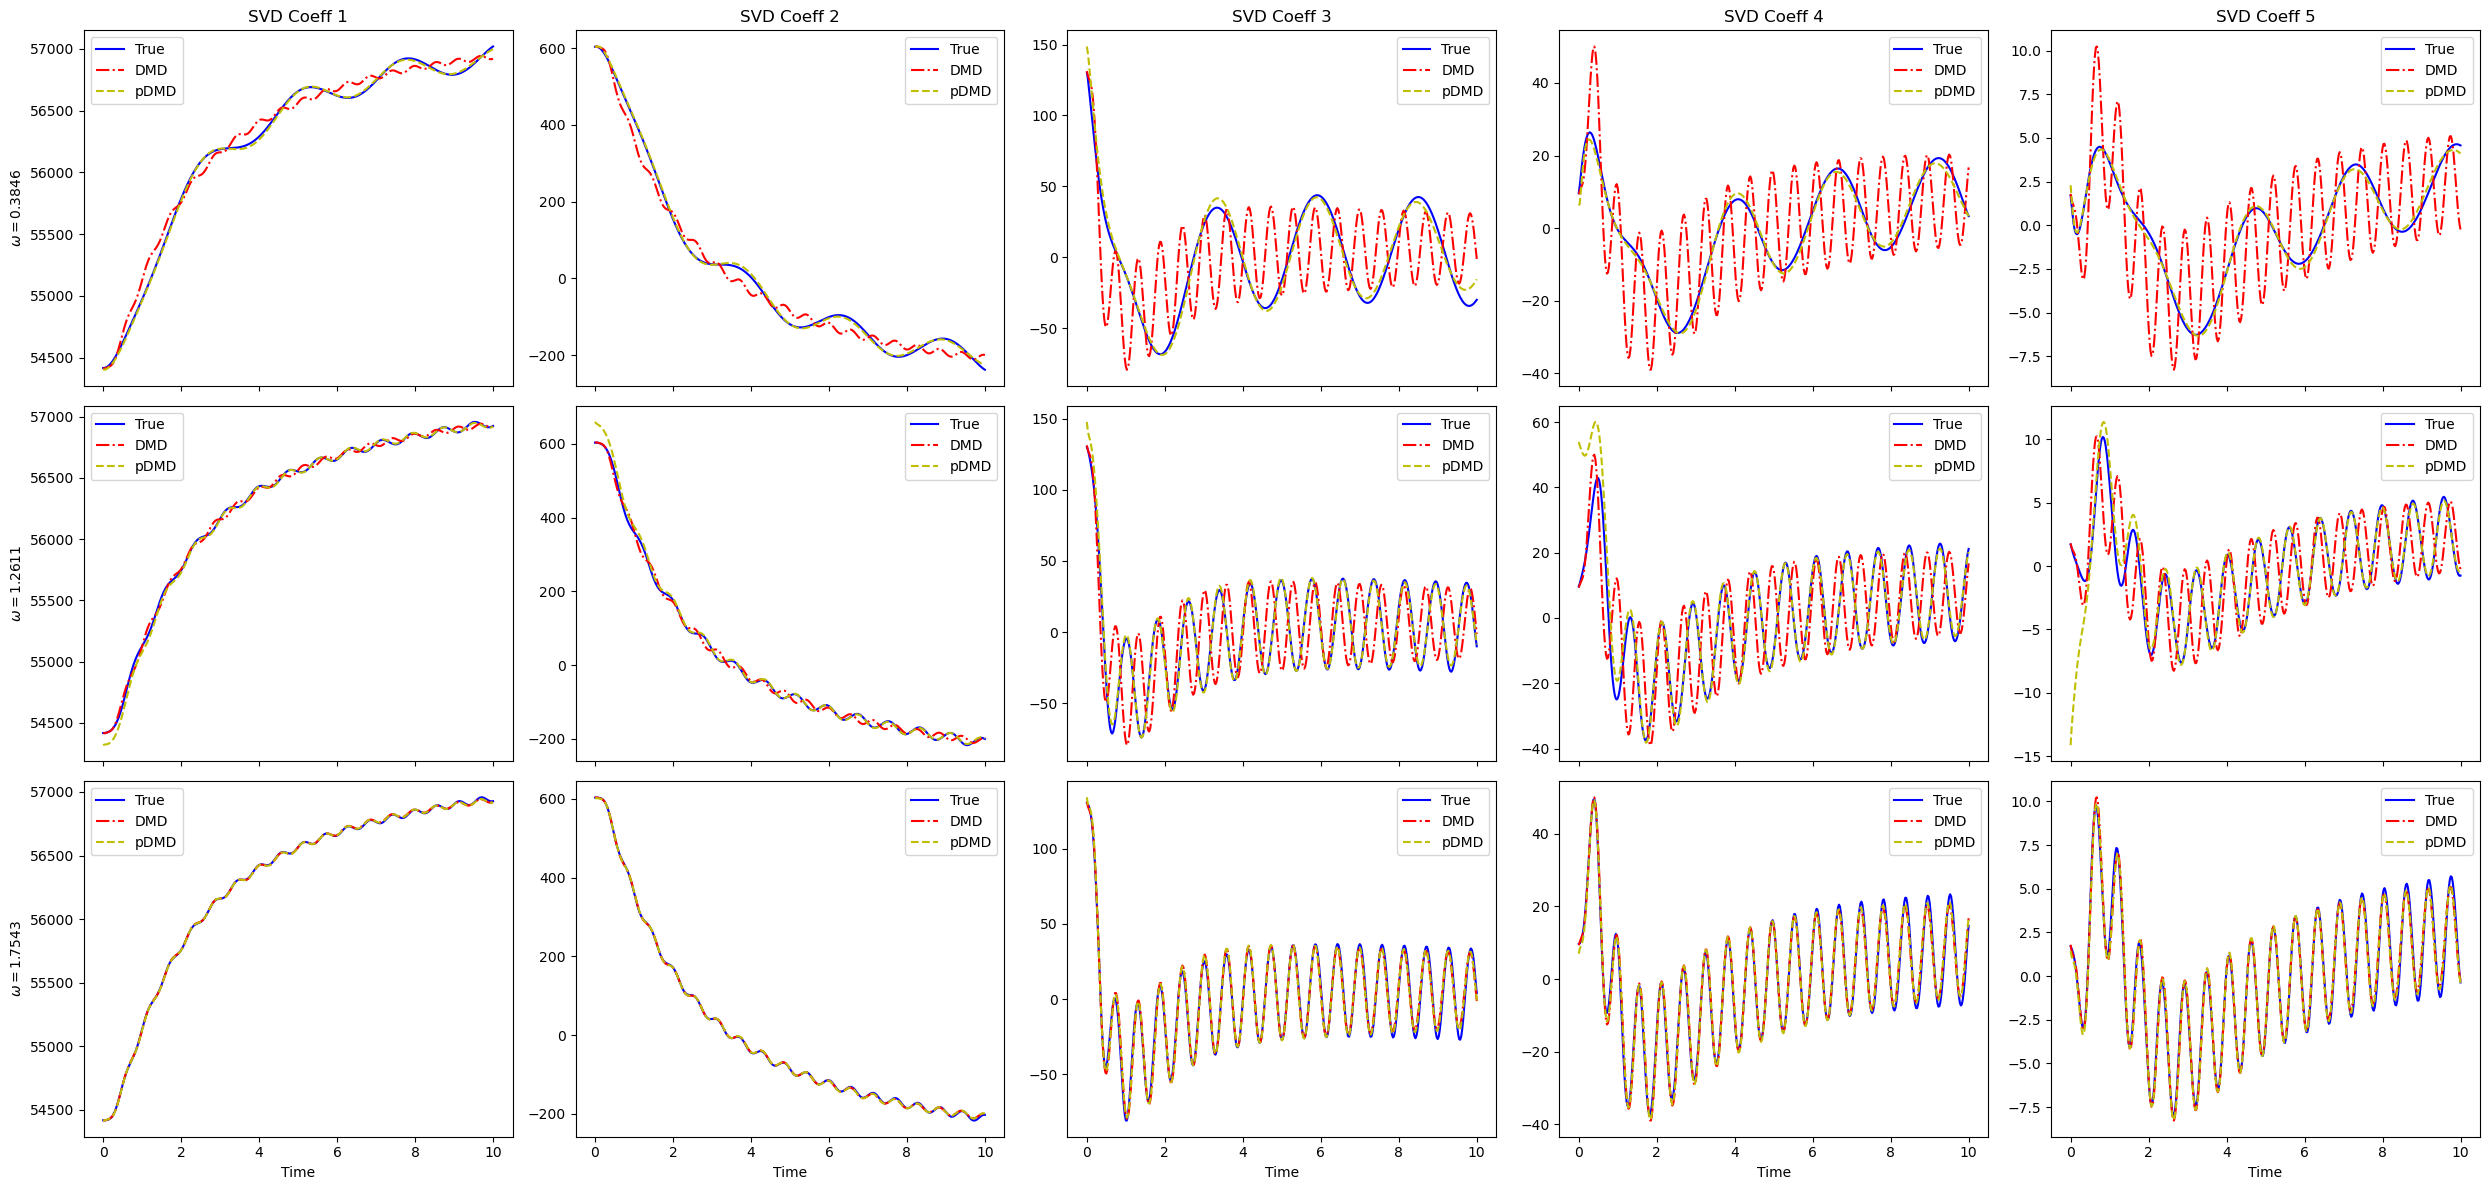

In [38]:
modes_to_plot = np.arange(0, 5, 1)

fig, axs = plt.subplots(len(test_idx), len(modes_to_plot), sharex=True, figsize=(len(modes_to_plot)*5, len(test_idx)*4))

for mu_test in range(len(test_idx)):

    if rkoi.scaler is not None:
        dmd_rec_pod_coeff   = rkoi.scaler.inverse_transform(_dmd_test.forecast(times).real.T).T
    else:
        dmd_rec_pod_coeff   = _dmd_test.forecast(times).real

    model = {
            'modes': optdmds_test[mu_test].modes,
            'amplitudes': optdmds_test[mu_test].amplitudes,
            'eigs': optdmds_test[mu_test].eigs,
        }
    
    pred_model = rkoi.predict_kop(omega[test_idx][mu_test])
    predicted_pod_coeff = rkoi.forecast(pred_model, times)

    for ii, idx in enumerate(modes_to_plot):
        axs[mu_test, ii].plot(times, test_pod_coeff[mu_test, :, idx], 'b', label='True')
        axs[mu_test, ii].plot(times, dmd_rec_pod_coeff[idx], 'r-.', label='DMD')
        axs[mu_test, ii].plot(times, predicted_pod_coeff[idx], 'y--', label='pDMD')
        axs[mu_test, ii].legend()

        if mu_test == 0:
            axs[mu_test, ii].set_title(f'SVD Coeff {idx+1}')
            
        if ii == 0:
            axs[mu_test, ii].set_ylabel(f'$\omega = {omega[test_idx][mu_test]}$')

        if mu_test == len(test_idx)-1:
            axs[mu_test, ii].set_xlabel('Time')

plt.tight_layout()
fig.savefig(path_res + 'pdmd_rkoi_test_latent_dyn.pdf', format='pdf', dpi=200, bbox_inches='tight')


Let us decode to the high-dimensional space and compare the results

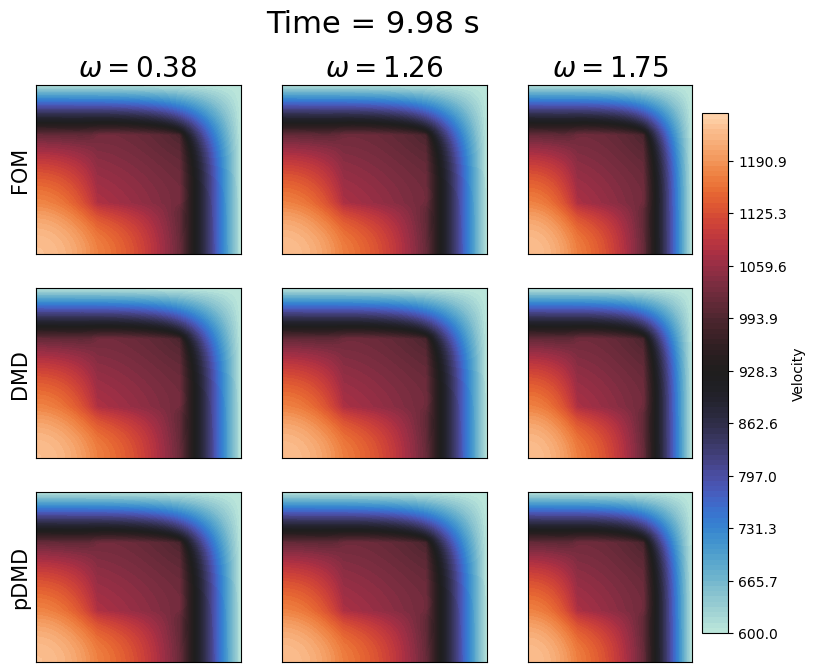

In [41]:
field_to_plot = 2

recons = [[], []]

labels = ['DMD', 'pDMD']

for i, mu_i in enumerate(test_idx):

    dmd_rec_pod_coeff   = rkoi.scaler.inverse_transform(optdmds_test[i].forecast(times).real.T).T
    # dmd_rec_pod_coeff   = optdmds_test[i].forecast(times).real
    true_model = {
                'modes': optdmds_test[i].modes,
                'amplitudes': optdmds_test[i].amplitudes,
                'eigs': optdmds_test[i].eigs,
            }

    pred_model = rkoi.predict_kop(omega[mu_i])
    predicted_pod_coeff = rkoi.forecast(pred_model, times)

    recons[0].append(spatial_modes[:, :rkoi.rank] @ dmd_rec_pod_coeff)
    recons[1].append(spatial_modes[:, :rkoi.rank] @ predicted_pod_coeff)

for tt in range(49, len(times), 50):
    fig, axs = plotter.plotting_reconstruction( np.arange(0, len(test_idx), 1), test_snapshots, omega[test_idx], times, tt, 
                                               field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Monolithic pDMD from pyDMD - pDMD-mono
This version is embedded in pyDMD and is used to build a single DMD model for all the training parameters.

In [51]:
from pydmd import ParametricDMD, DMD
from ezyrb import POD, RBF
import warnings
warnings.filterwarnings("ignore")

interpolator = RBF()

rank_monolithic = 2
rom_monolithic  = POD(rank=rank_monolithic, method='randomized_svd')

dmd_monolithic  = DMD(svd_rank=-1)
pdmd_monolithic = ParametricDMD(dmd_monolithic, rom_monolithic, interpolator)

Let us train the monolithic model with the snapshot has to be re-arranged as follows

\begin{equation*}
  N_p \times N_h \times N_{t}
\end{equation*}

In [52]:
pdmd_monolithic.fit(
    np.swapaxes(train_snapshots, 1, 2), 
    omega[train_idx]
)

Let us assign the time to the monolithic DMD mode

In [53]:
pdmd_monolithic.original_time["t0"]   = times[0]
pdmd_monolithic.original_time["tend"] = times[-1] - 1e-12
pdmd_monolithic.original_time["dt"]   = times[1]  - times[0]

pdmd_monolithic.dmd_time["t0"]   = times[0]
pdmd_monolithic.dmd_time["tend"] = times[-1] - 1e-12
pdmd_monolithic.dmd_time["dt"]   = times[1]  - times[0]

Let us make some contour plots of the reconstruction of the DMD models for training parameters

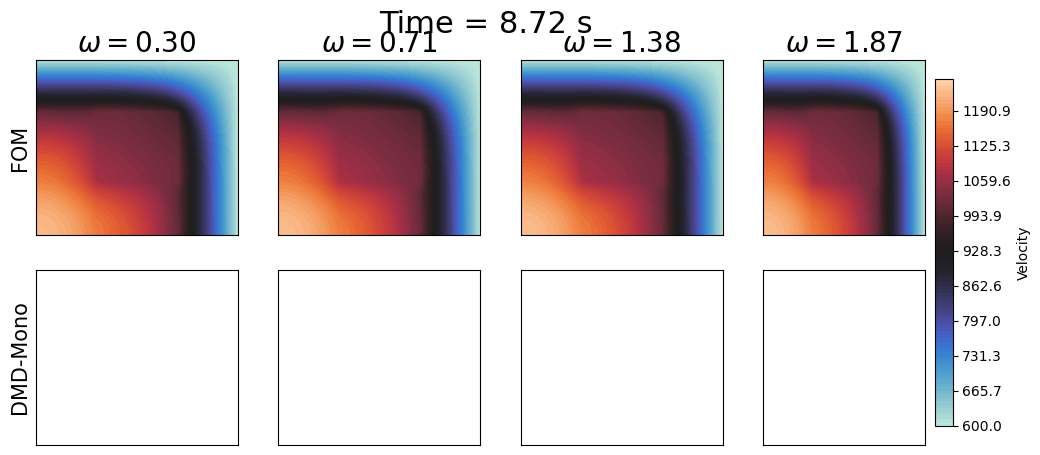

In [54]:
from IPython.display import clear_output as clc

field_to_plot = 2

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_idx), 4, replace=False))

recons = [list()]
for mu_i in params_to_plot:
    idx_to_rec = np.arange(rank_monolithic * mu_i, rank_monolithic * (mu_i+1))
    recons[-1].append(pdmd_monolithic._spatial_pod.modes @ pdmd_monolithic._dmd.reconstructed_data[idx_to_rec])

labels = ['DMD-Mono']

for tt in range(49, len(times), 150):
    fig, axs = plotter.plotting_reconstruction( params_to_plot, train_snapshots, omega, times, tt, 
                            field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Let us test the model on the test set of parameters

In [55]:
pdmd_monolithic.parameters  = omega[test_idx]
recon_monolithic  = pdmd_monolithic.reconstructed_data.real

Let us plot the results

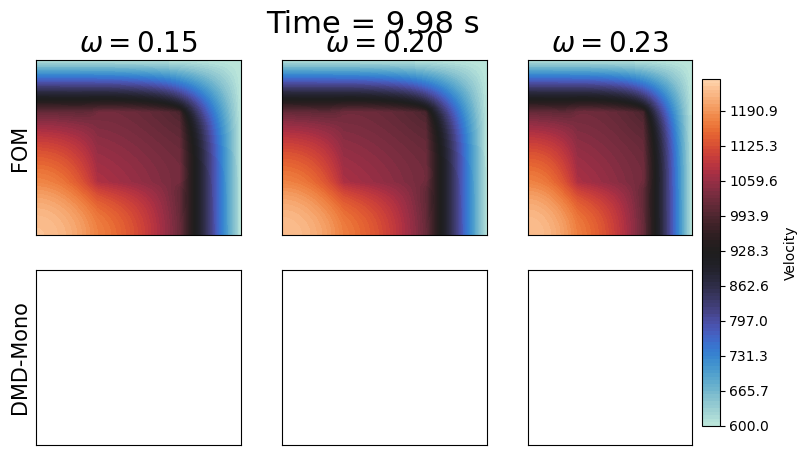

In [58]:
recons = [list()]
for mu_i in range(len(test_idx)):
    recons[-1].append(recon_monolithic[mu_i])

labels = ['DMD-Mono']

for tt in range(49, len(times), 50):
    fig, axs = plotter.plotting_reconstruction( np.arange(0, len(test_idx), 1), test_snapshots, omega, times, tt, 
                            field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Partitioned pDMD from pyDMD - pDMD-part
This version is embedded in pyDMD and is similar to the ROI, the output of the training DMD models is interpolated.

In [60]:
from pydmd import ParametricDMD, DMD, HankelDMD
from ezyrb import POD, RBF
import warnings
warnings.filterwarnings("ignore")

interpolator = RBF()

rank_partitioned = 10
rom_partitioned  = POD(rank=rank_partitioned, method='randomized_svd')

# dmds_partitioned = [HankelDMD(svd_rank=-1, d=10) for _ in range(len(train_idx))]
dmds_partitioned = [DMD(svd_rank=-1) for _ in range(len(train_idx))]

pdmd_partitioned = ParametricDMD(dmds_partitioned, rom_partitioned, interpolator)

Let us train the monolithic model with the snapshot has to be re-arranged as follows

\begin{equation*}
  N_p \times N_h \times N_{t}
\end{equation*}

In [61]:
pdmd_partitioned.fit(
    np.swapaxes(train_snapshots, 1, 2), 
    omega[train_idx]
)

Let us assign the time to the partitioned DMD mode

In [62]:
pdmd_partitioned.original_time["t0"]   = times[0]
pdmd_partitioned.original_time["tend"] = times[-1] - 1e-12
pdmd_partitioned.original_time["dt"]   = times[1]  - times[0]

pdmd_partitioned.dmd_time["t0"]   = times[0]
pdmd_partitioned.dmd_time["tend"] = times[-1] - 1e-12
pdmd_partitioned.dmd_time["dt"]   = times[1]  - times[0]

Let us make some contour plots of the reconstruction of the DMD models for training parameters

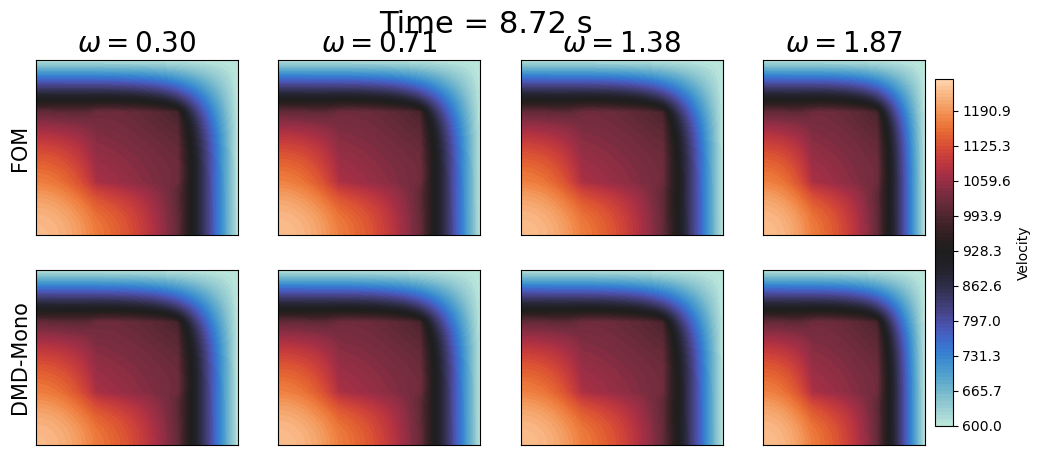

In [63]:
from IPython.display import clear_output as clc

field_to_plot = 2

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_idx), 4, replace=False))

recons = [list()]
for mu_i in params_to_plot:
    idx_to_rec = np.arange(rank_partitioned * mu_i, rank_partitioned * (mu_i+1))
    recons[-1].append(pdmd_partitioned._spatial_pod.modes @ pdmd_partitioned._dmd[mu_i].reconstructed_data)

labels = ['DMD-Mono']

for tt in range(49, len(times), 150):
    fig, axs = plotter.plotting_reconstruction( params_to_plot, train_snapshots, omega, times, tt, 
                            field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Let us test the model on the test set of parameters

In [64]:
pdmd_partitioned.parameters  = omega[test_idx]
recon_partitioned  = pdmd_partitioned.reconstructed_data.real

Let us plot the results

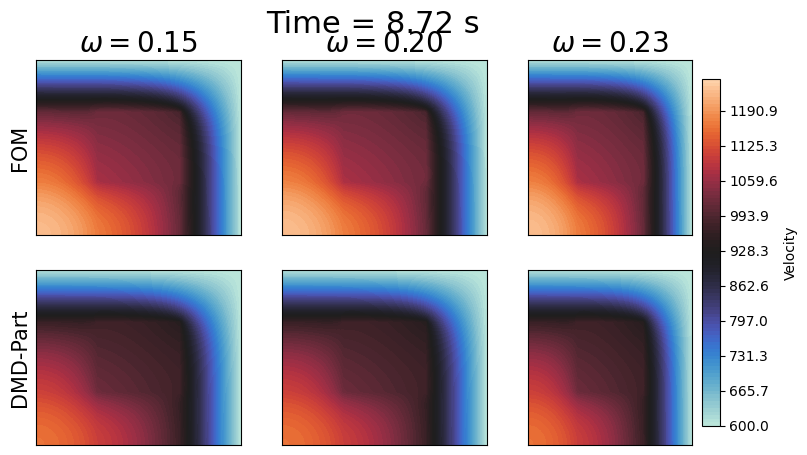

In [65]:
recons = [list()]
for mu_i in range(len(test_idx)):
    recons[-1].append(recon_partitioned[mu_i])

labels = ['DMD-Part']

for tt in range(49, len(times), 150):
    fig, axs = plotter.plotting_reconstruction( np.arange(0, len(test_idx), 1), test_snapshots, omega, times, tt, 
                            field_to_plot=field_to_plot,
                            recons = recons, labels = labels, levels=levels[field_to_plot], cmap = cmaps[field_to_plot], show_residuals=False, length_plot=3)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Comparison of the different methods
In this last section, the test set will be used to compare the different methods.
The Euclidian norm is taken spatially of the residual field between the predicted and the actual field, then the time and parameter average is made.

In [70]:
from time import process_time

labels = ['ROI', 'RKOI', 'Monolithic', 'Partitioned']
recons = [list() for _ in range(len(labels))]
compt_times = np.zeros((len(test_idx), len(labels)))

for ii, mu in enumerate(omega[test_idx]):

    # Reduced Operator Interpolation (ROI)
    start = process_time()
    recons[0].append(np.dot(spatial_modes[:, :roi.rank], 
                            roi.advance(test_pod_coeff[ii, 0, :roi.rank], len(times), mu).T))
    compt_times[ii, 0] = process_time() - start

    # Reduced Koopman Operator Interpolation (RKOI)
    start = process_time()
    pred_model = rkoi.predict_kop(mu)
    predicted_pod_coeff = rkoi.forecast(pred_model, times)
    recons[1].append(spatial_modes[:, :rkoi.rank] @ predicted_pod_coeff)
    compt_times[ii, 1] = process_time() - start

    # Monolithic DMD
    start = process_time()
    pdmd_monolithic.parameters = [mu]
    recons[2].append(pdmd_monolithic.reconstructed_data.real)
    compt_times[ii, 2] = process_time() - start


    # Partitioned DMD
    start = process_time()
    pdmd_partitioned.parameters = [mu]
    recons[3].append(pdmd_partitioned.reconstructed_data.real)
    compt_times[ii, 3] = process_time() - start

Let us compare the computational times

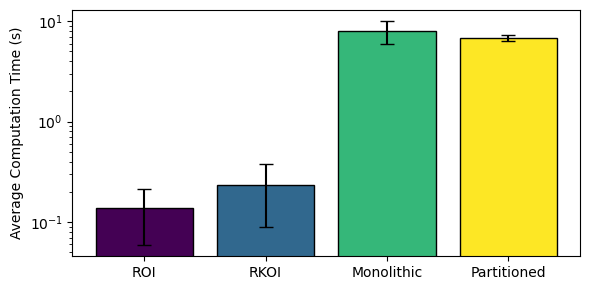

In [71]:
from matplotlib import cm

mean_times = np.mean(compt_times, axis=0)
std_times = np.std(compt_times, axis=0)

fig, ax = plt.subplots(figsize=(6, 3))

ax.bar(labels, mean_times, yerr=std_times, capsize=5, color=cm.viridis(np.linspace(0,1,len(labels))), edgecolor='black')

ax.set_ylabel('Average Computation Time (s)')
ax.set_yscale('log')

plt.tight_layout()
fig.savefig(path_res + 'computation_times.pdf', format='pdf', dpi=200, bbox_inches='tight')


Here the errors are computed and plotted

In [68]:
_recons = recons.copy()

for ii in range(len(test_idx)):
    print(recons[0][ii].shape, recons[1][ii].shape, recons[2][ii].shape, recons[3][ii].shape)

for ii in range(len(omega[test_idx])):
    
    recons[2][ii] = _recons[2][ii][0]
    recons[3][ii] = np.concatenate([_recons[3][ii][0], _recons[3][ii][0, :, -1].reshape(-1,1)], axis=1)
    

(10782, 401) (10782, 401) (1, 10782, 401) (1, 10782, 401)
(10782, 401) (10782, 401) (1, 10782, 401) (1, 10782, 401)
(10782, 401) (10782, 401) (1, 10782, 401) (1, 10782, 401)


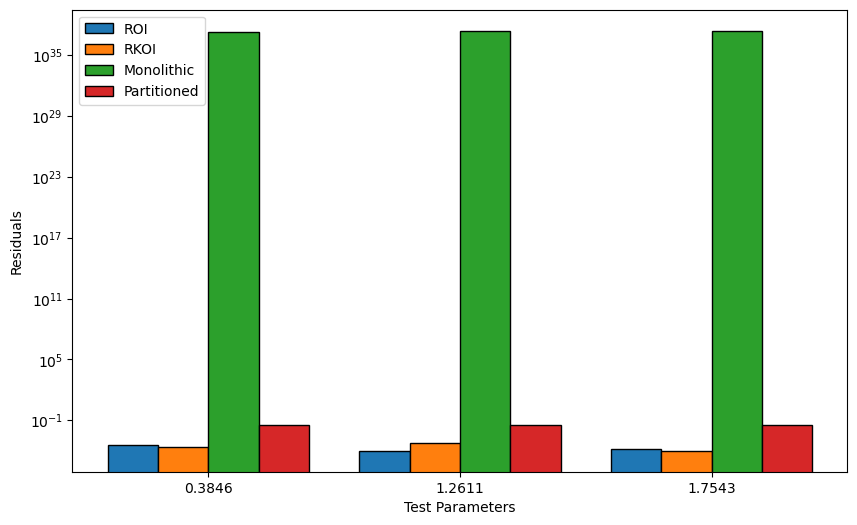

In [73]:
resids = np.zeros((len(omega[test_idx]), len(labels)))

for ii in range(len(omega[test_idx])):
    for jj in range(len(labels)):
        resids[ii, jj] = np.linalg.norm(recons[jj][ii] - test_snapshots[ii].T) / np.linalg.norm(test_snapshots[ii].T)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
positions = np.arange(len(omega[test_idx]))

for i, label in enumerate(labels):
    ax.bar(positions + i * bar_width, resids[:, i], bar_width, label=label, edgecolor='black')

ax.set_xlabel('Test Parameters')
ax.set_ylabel('Residuals')
ax.set_yscale('log')
ax.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
ax.set_xticklabels(omega[test_idx])
ax.legend()

fig.savefig(path_res + 'residual_errors.pdf', format='pdf', dpi=200, bbox_inches='tight')

Let us generate the frames and make the video

In [38]:
# from tools.plots import make_mp4, make_gif
# from matplotlib.colors import Normalize
# from tqdm import tqdm

# # Define colorbar
# vmin = test_snapshots.min()
# vmax = test_snapshots.max()

# cmap = cmaps[field_to_plot]
# norm = Normalize(vmin=vmin, vmax=vmax)
# scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

# # Define fig path
# path_fig = path_res+'Figs/'
# os.makedirs(path_fig, exist_ok=True)

# for tt in tqdm(range(200, len(times), 5)):
#     fig, axs = plotter.plotting_reconstruction( np.arange(0, len(test_idx), 1), test_snapshots, Re_numbers[test_idx], times, tt, 
#                             recons = recons, labels = labels, levels=levels, cmap = cmap, show_residuals=False, length_plot=5)

#     fig.savefig(path_fig + f'comparison_{tt:04d}.png', format='png', dpi=200, bbox_inches='tight')
#     plt.close(fig)

# path_video = 'SupportingVideos/'
# os.makedirs(path_video, exist_ok=True)

# make_mp4(path_fig, path_video+'flowCylFenics.mp4', fps=15)
# make_gif(path_fig, path_video+'flowCylFenics.gif', fps=15)

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [03:07<00:00,  1.17s/it]
[_io.py:561 -         write_frames() ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1751, 1997) to (1760, 2000) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x10583100] Warning: data is not aligned! This can lead to a speed loss
